# Import all required library

In [136]:
%pip install matplotlib pandas numpy seaborn wordcloud emoji langid

Note: you may need to restart the kernel to use updated packages.


In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import facebook_scraper as fs
import langid
import emoji

# Craw comment data

In [156]:
raw_df = pd.read_csv('Data/perfect_data.csv')
post_ids_comment = np.array(raw_df.loc[raw_df['image'] == True, 'post_id'])
post_ids_comment.size

32

In [ ]:
# Danh sách để lưu trữ dữ liệu comment
all_comments = []

for post_id in post_ids_comment:
    gen = fs.get_posts(
        post_urls=[post_id],
        options={"comments": 27, "progress": True}
    )
    post = next(gen)
    comments = post['comments_full']
    
    # Thu thập thông tin từ mỗi comment và thêm vào danh sách all_comments
    for comment in comments:
        comment_data = {
            'post_id': post_id,
            'comment_id': comment['comment_id'],
            'comment_url': comment['comment_url'],
            'commenter_id': comment['commenter_id'],
            'commenter_name': comment['commenter_name'],
            'comment_text': comment['comment_text'],
            'comment_time' : comment['comment_time']
        }
        all_comments.append(comment_data)


# Tạo DataFrame từ danh sách all_comments
df_comments = pd.DataFrame(all_comments)

# Lưu DataFrame vào file CSV
df_comments.to_csv('Data/comments.csv', index=False)


# Overview

In [147]:
df = pd.read_csv('Data/comments.csv')
df.dropna(subset='comment_time', inplace=True)
# Calculating the length of each post
df['comment_length'] = df['comment_text'].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 0 to 934
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_id         934 non-null    int64 
 1   comment_id      934 non-null    int64 
 2   comment_url     934 non-null    object
 3   commenter_id    934 non-null    int64 
 4   commenter_name  934 non-null    object
 5   comment_text    934 non-null    object
 6   comment_time    934 non-null    object
 7   comment_length  934 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 65.7+ KB


# Comment analysis

In [146]:
# Tính tổng số lượt bình luận cho mỗi người
comment_counts = df.groupby('commenter_id')['comment_id'].count()

# Lấy top 5 người bình luận nhiều nhất
top_5_commenters = comment_counts.nlargest(10)

# Lấy dataframe chứa thông tin của top 5 người bình luận
top_5_info = df[df['commenter_id'].isin(top_5_commenters.index)]

# In ra tên và số lượt bình luận tương ứng
print("Top 5 người bình luận nhiều nhất:")
print(top_5_info.groupby(['commenter_id', 'commenter_name']).size().reset_index(name='comment_count'))

Top 5 người bình luận nhiều nhất:
      commenter_id                   commenter_name  comment_count
0       1845826778                     Naomi Muyoka             18
1  100000906162856                    Edvan Mineiro             10
2  100004809481284                       Purri Make             14
3  100006117607164                  Rebecca Chituwi             26
4  100007846239202          Md Ziaul Basher Bhuiyan             21
5  100011500534806              Vijayshankar Tiwari             18
6  100021878746098                 Abdulmecit Dogan             14
7  100052464531616                    Nishant Kumar             26
8  100055247477777                Molly MangoMhizha             10
9  100057412552284  Alavala Rosaiah Alavala Rosaiah             10


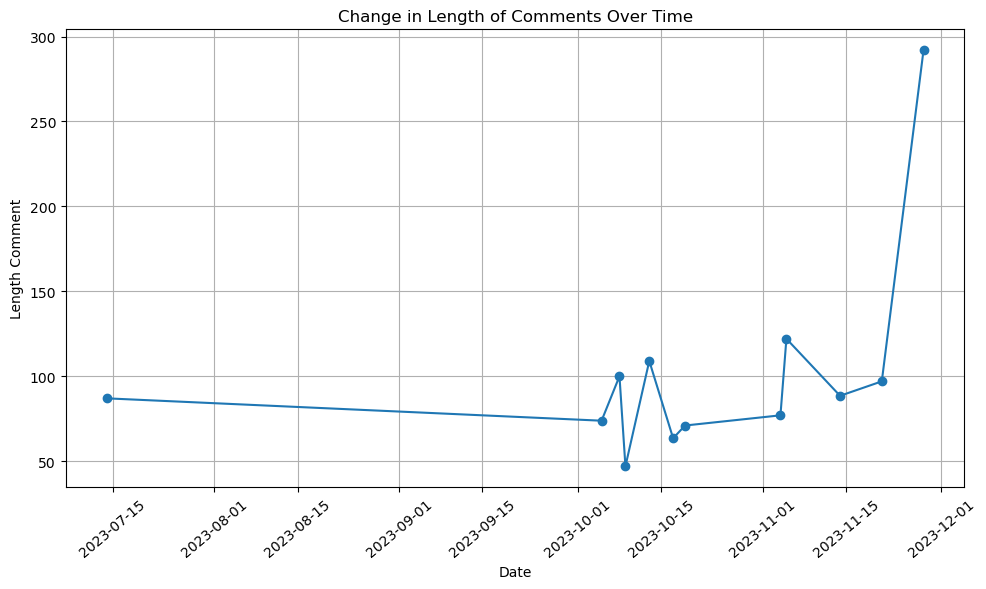

In [148]:
df['comment_time'] = pd.to_datetime(df['comment_time'])
# Group by date and sum the reaction counts
comment_length_by_date = df.groupby(df['comment_time'].dt.date)['comment_length'].mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(comment_length_by_date, marker='o', linestyle='-')
plt.title('Change in Length of Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Length Comment')
plt.xticks(rotation=40)
plt.grid(True)
plt.tight_layout()

Sự tương quan giữa độ dài post và độ dài comment

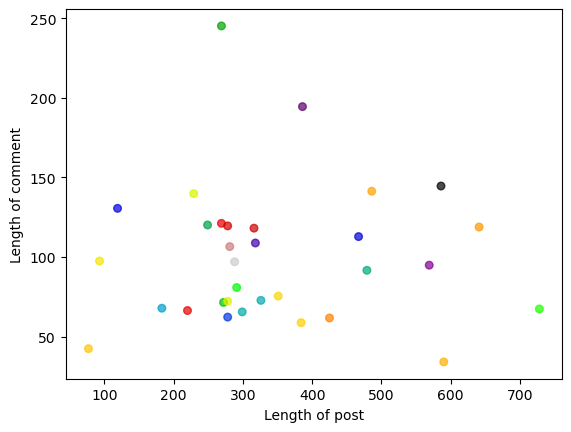

In [168]:
post_df = pd.read_csv('Data/perfect_data.csv')
# Lọc DataFrame để chỉ lấy các bài đăng có post_id nằm trong danh sách
filtered_df = post_df[post_df['post_id'].isin(post_ids_comment)]
# Chuyển cột 'post_length' thành một mảng ndarray
x = np.array(filtered_df['post_length']) # post_lengths_array
y = df.groupby('post_id')['comment_length'].mean() # Độ dài trung bình mỗi comment của post

colors = np.random.randint(100, size=(32))
plt.scatter(x, y, c=colors, s=30, alpha=0.7, cmap='nipy_spectral')
plt.xlabel('Length of post')
plt.ylabel('Length of comment')
plt.show()


# Từ khóa xuất hiện nhiều nhất trong comment

    Clean comment data

In [149]:
def contains_emoji(comment):
    # Kiểm tra xem comment có chứa ít nhất một emoji không
    return any(emoji.is_emoji(c) for c in comment)

def filter_latin_comments(comment):
    lang, confidence = langid.classify(comment)
    return lang == 'en'  # chỉ giữ lại comment tiếng Anh

df = df[~df['comment_text'].apply(contains_emoji)]
df = df[df['comment_text'].apply(filter_latin_comments)]

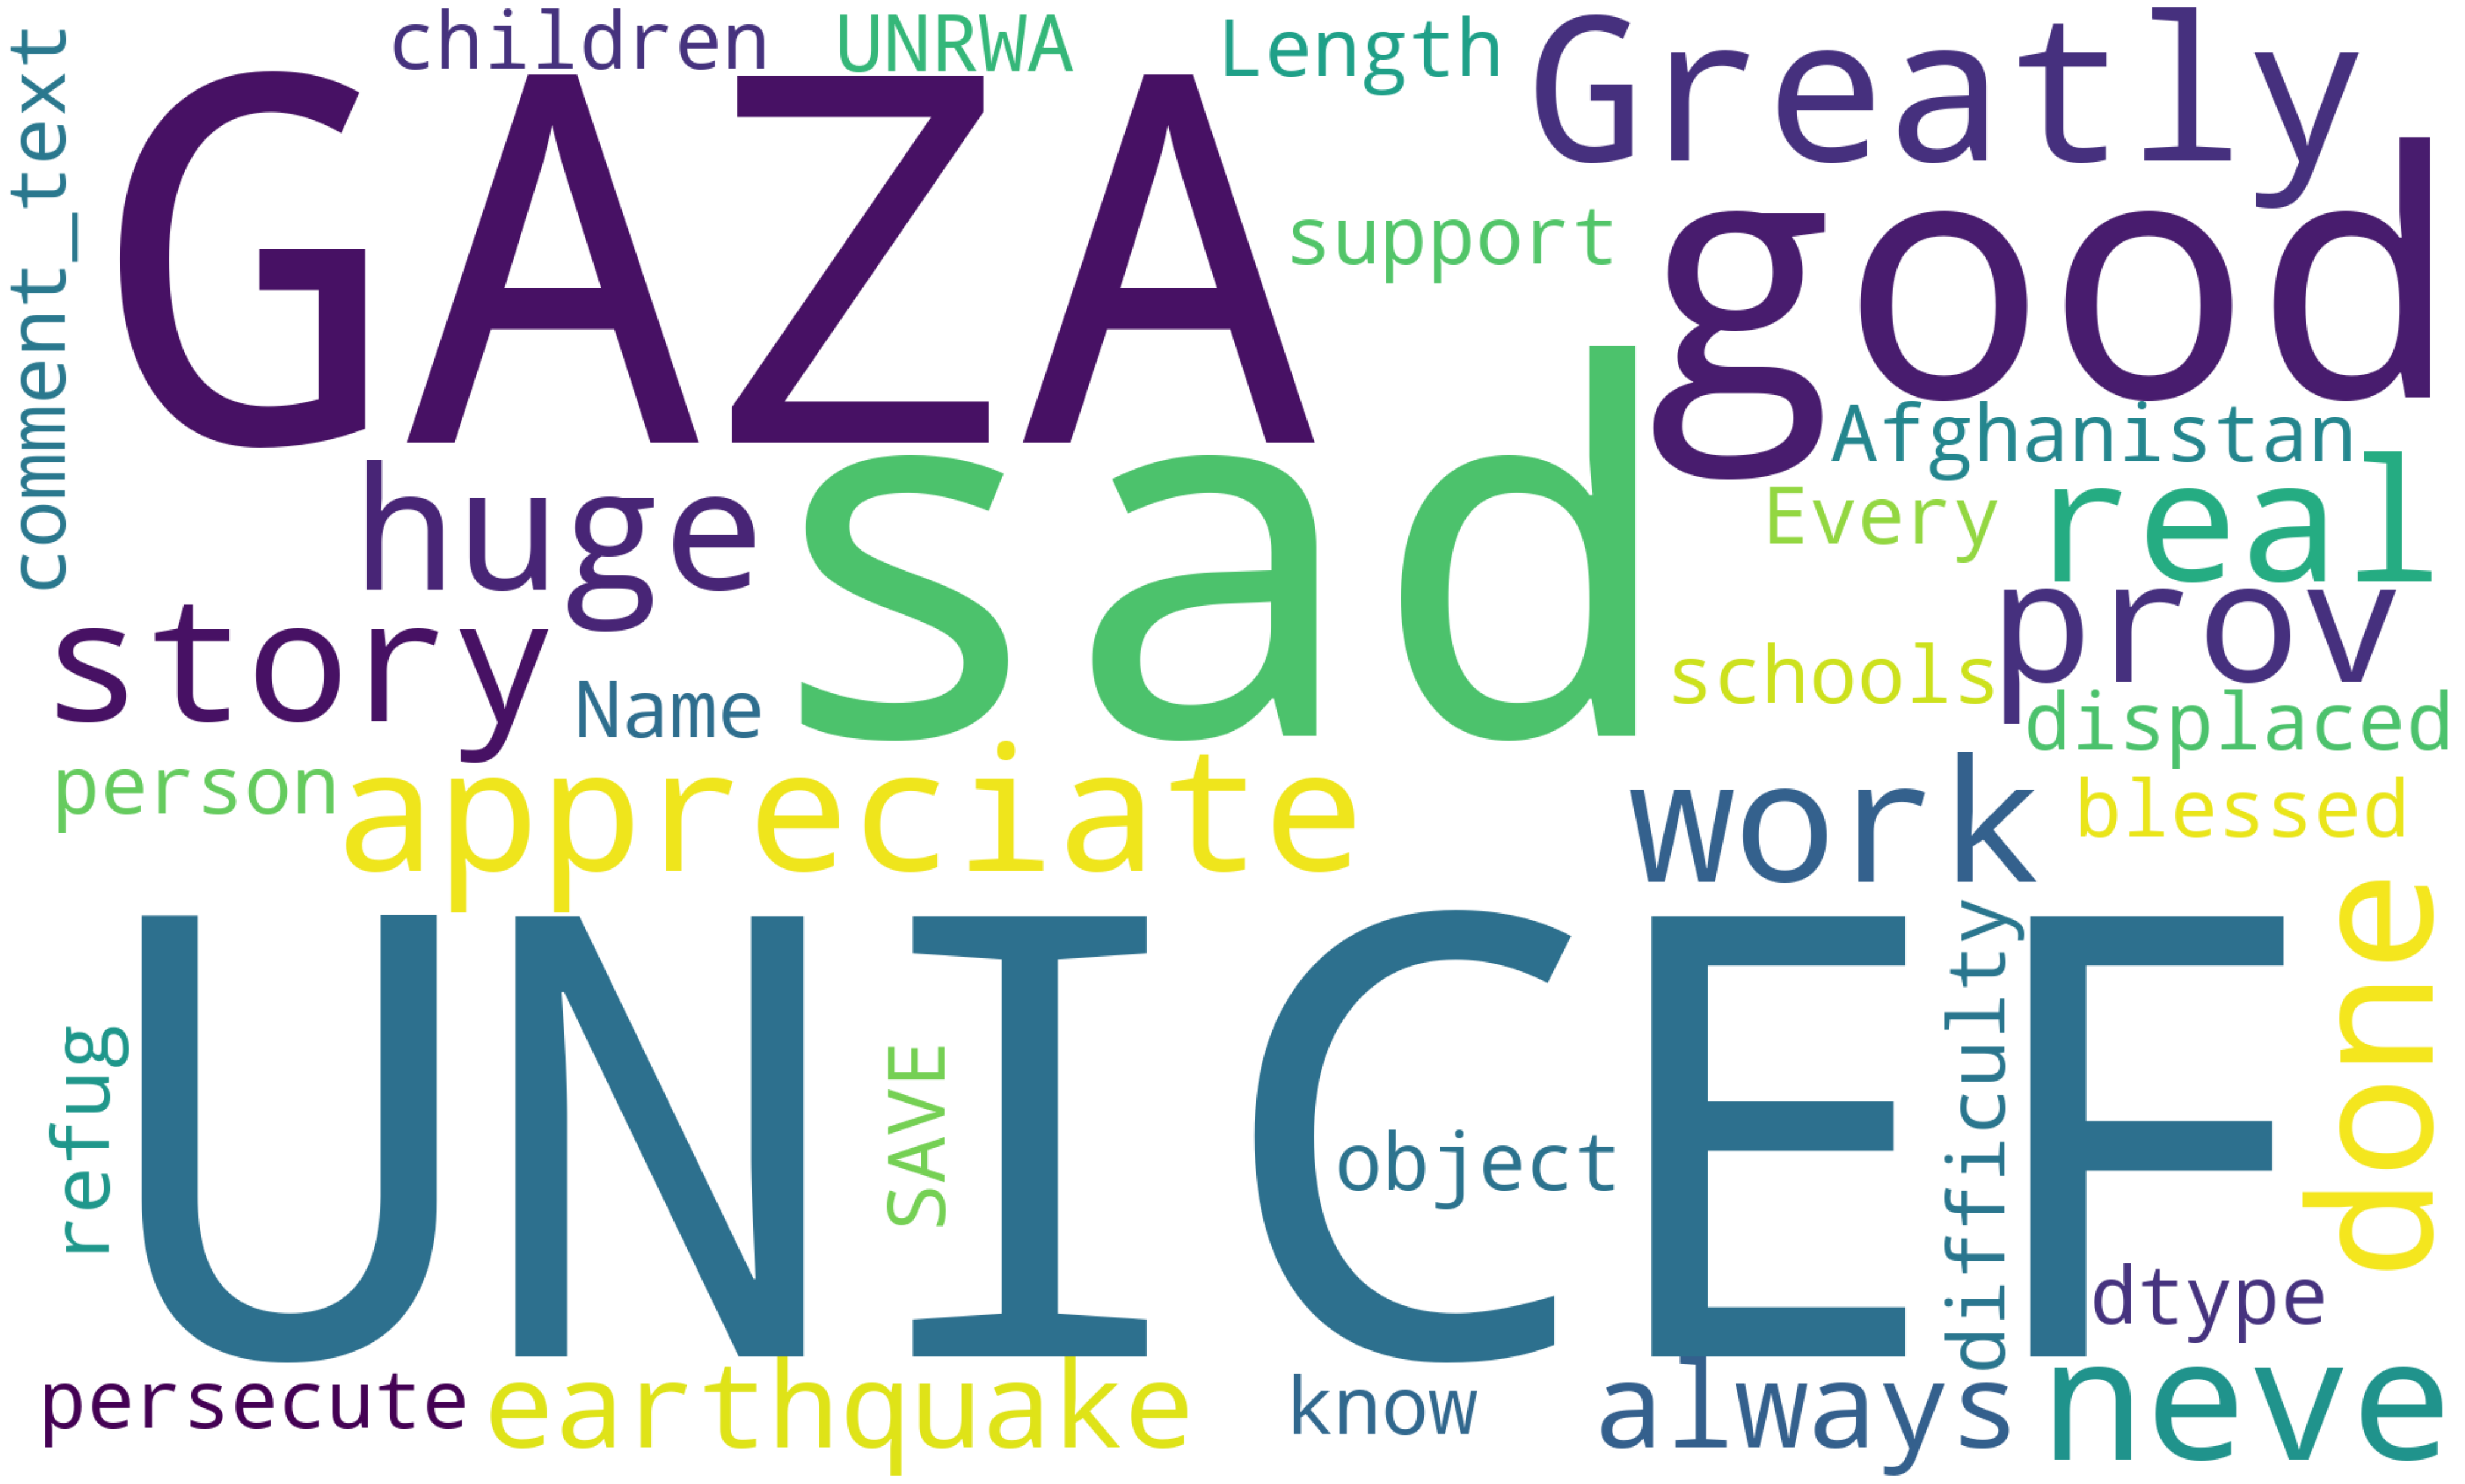

In [150]:
text = str(df['comment_text'])
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1200
                         ).generate(text)
plt.figure(figsize=(45,25))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()